In [1]:
import matplotlib.colors as mcolors
import matplotlib.pyplot as plt
import matplotlib.ticker as mticker

import numpy as np
import pandas as pd
from scipy import stats

from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
import watermark

plt.style.use('./CDS_paper.mplstyle')
tab10 = plt.get_cmap("tab10").colors
tab20 = plt.get_cmap("tab20").colors

%matplotlib inline
%load_ext watermark
%watermark -n -v -m -g -iv

Python implementation: CPython
Python version       : 3.9.0
IPython version      : 7.19.0

Compiler    : Clang 12.0.0 (clang-1200.0.32.27)
OS          : Darwin
Release     : 20.1.0
Machine     : x86_64
Processor   : i386
CPU cores   : 12
Architecture: 64bit

Git hash: 

watermark : 2.1.0
pandas    : 1.1.4
matplotlib: 3.3.3
scipy     : 1.5.4
numpy     : 1.19.4



Load cognitive distortion schemata (CDS)

In [2]:
_CDS = pd.read_csv("data/list_of_CDS.tsv", sep="\t", index_col="markers")

Calculate VADER scores for each CDS

In [3]:
VADER = SentimentIntensityAnalyzer()
_CDS["VADER"] = _CDS.apply(lambda x: VADER.polarity_scores(x.name)['compound'], axis=1)

Load VADER scores per tweet

In [4]:
D_VADER = pd.read_csv("results/D_per_tweet_VADER_score.tsv.gz", sep="\t", index_col=[0])
R_VADER = pd.read_csv("results/R_per_tweet_VADER_score.tsv.gz", sep="\t", index_col=[0])

Load CDS annotations per tweet

In [6]:
D_CDS = pd.read_csv("results/D_per_tweet_CDS.tsv.gz", sep="\t", index_col=[0]).sum(axis=1) > 0
R_CDS = pd.read_csv("results/R_per_tweet_CDS.tsv.gz", sep="\t", index_col=[0]).sum(axis=1) > 0

Define distribution constants

In [7]:
bin_width = 0.05
bins = np.arange(-1.025, 1.075, bin_width)
kde_bins = np.arange(-1.025, 1.075, bin_width / 10)

Determine distributions of non-zero values

In [8]:
D_hist, _ = np.histogram(D_VADER.loc[D_VADER["VADER"] != 0, "VADER"], bins, density=True)
R_hist, _ = np.histogram(R_VADER.loc[R_VADER["VADER"] != 0, "VADER"], bins, density=True)
D_CDS_hist, _ = np.histogram(D_VADER.loc[(D_VADER["VADER"] != 0) & D_CDS, "VADER"], bins, density=True)
R_CDS_hist, _ = np.histogram(R_VADER.loc[(R_VADER["VADER"] != 0) & R_CDS, "VADER"], bins, density=True)
CDS_hist, _ = np.histogram(_CDS.loc[_CDS["VADER"] != 0, "VADER"], bins, density=True)

Calculate kernel densities (KDE)

In [9]:
D_KDE = stats.gaussian_kde(D_VADER.loc[D_VADER["VADER"] != 0, "VADER"])(kde_bins)
R_KDE = stats.gaussian_kde(R_VADER.loc[R_VADER["VADER"] != 0, "VADER"])(kde_bins)
D_CDS_KDE = stats.gaussian_kde(D_VADER.loc[(D_VADER["VADER"] != 0) & D_CDS, "VADER"])(kde_bins)
R_CDS_KDE = stats.gaussian_kde(R_VADER.loc[(R_VADER["VADER"] != 0) & R_CDS, "VADER"])(kde_bins)
CDS_KDE = stats.gaussian_kde(_CDS.loc[_CDS["VADER"] != 0, "VADER"])(kde_bins)

Define plotting functions

In [10]:
def add_limits(ax):
    ax.set_xlim(-1.025, 1.025)
    ax.xaxis.set_major_locator(mticker.MultipleLocator(0.25))
    ax.xaxis.set_minor_locator(mticker.MultipleLocator(0.05))
    ax.set_ylim(0, 1.5)
    ax.yaxis.set_major_locator(mticker.MultipleLocator(1))
    ax.yaxis.set_minor_locator(mticker.MultipleLocator(0.1))
    return ax

# Figure

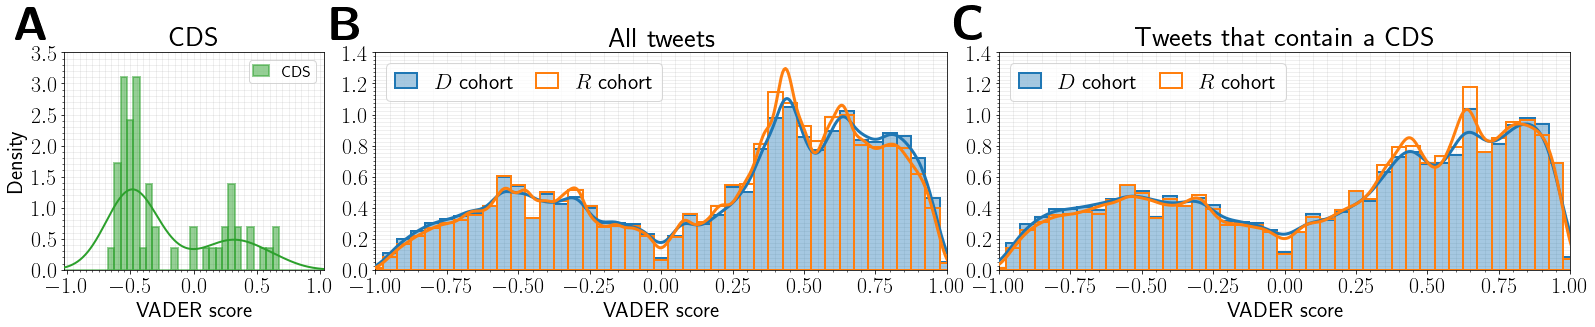

In [11]:
fig = plt.figure(figsize=(27, 4))
gs = fig.add_gridspec(4, 5)

ax = fig.add_subplot(gs[:, 0])
ax.set_title(r"CDS")
ax.bar(bins[:-1], CDS_hist, width=bin_width, align="edge",
       alpha=0.5, lw=2, fc="C2", ec="C2", label=r"CDS", zorder=2)
ax.plot(kde_bins, CDS_KDE, lw=2, color="C2", zorder=3)
ax.legend(fontsize=16, loc="upper right", bbox_to_anchor=(1.0, 1.0), handlelength=1, borderpad=0.25)
ax.set_xlim(-1.025, 1.025)
ax.xaxis.set_major_locator(mticker.MultipleLocator(0.5))
ax.xaxis.set_minor_locator(mticker.MultipleLocator(0.05))
ax.set_xlabel(r"VADER score")
ax.set_ylim(0, 3.5)
ax.yaxis.set_major_locator(mticker.MultipleLocator(0.5))
ax.yaxis.set_minor_locator(mticker.MultipleLocator(0.1))
ax.set_ylabel(r"Density")

ax = fig.add_subplot(gs[:, 1:3])
ax.set_title(r"All tweets")
ax.bar(bins[:-1], D_hist, width=bin_width, align="edge", lw=2,
       fc=(*tab10[0], 0.4), ec="C0", label=r"$D$ cohort", zorder=2)
ax.bar(bins[:-1], R_hist, width=bin_width, align="edge", lw=2,
       fc=(*tab10[1], 0.0), ec="C1", label=r"$R$ cohort", zorder=2)

ax.plot(kde_bins, D_KDE, color="C0", zorder=4)
ax.plot(kde_bins, R_KDE, color="C1", zorder=4)
ax.set_xlim(-1, 1)
ax.xaxis.set_major_locator(mticker.MultipleLocator(0.25))
ax.xaxis.set_minor_locator(mticker.MultipleLocator(0.05))
ax.set_ylim(0, 1.4)
ax.yaxis.set_major_locator(mticker.MultipleLocator(0.2))
ax.yaxis.set_minor_locator(mticker.MultipleLocator(0.025))
ax.legend(fontsize=22, ncol=2, loc="upper left", handlelength=1, columnspacing=1)
ax.set_xlabel(r"VADER score")

ax = fig.add_subplot(gs[:, 3:5])
ax.set_title(r"Tweets that contain a CDS")
ax.bar(bins[:-1], D_CDS_hist, width=bin_width, align="edge", lw=2,
       fc=(*tab10[0], 0.4), ec="C0", label=r"$D$ cohort", zorder=2)
ax.bar(bins[:-1], R_CDS_hist, width=bin_width, align="edge", lw=2,
       fc=(*tab10[1], 0.0), ec="C1", label=r"$R$ cohort", zorder=2)

ax.plot(kde_bins, D_CDS_KDE, color="C0", zorder=4)
ax.plot(kde_bins, R_CDS_KDE, color="C1", zorder=4)
ax.set_xlim(-1, 1)
ax.xaxis.set_major_locator(mticker.MultipleLocator(0.25))
ax.xaxis.set_minor_locator(mticker.MultipleLocator(0.05))
ax.set_ylim(0, 1.4)
ax.yaxis.set_major_locator(mticker.MultipleLocator(0.2))
ax.yaxis.set_minor_locator(mticker.MultipleLocator(0.025))
ax.legend(fontsize=22, ncol=2, loc="upper left", handlelength=1, columnspacing=1)
ax.set_xlabel(r"VADER score")

fig.text(0.1, 0.925, r"\textbf{A}", fontsize=48, zorder=6)
fig.text(0.2625, 0.925, r"\textbf{B}", fontsize=48, zorder=6)
fig.text(0.5825, 0.925, r"\textbf{C}", fontsize=48, zorder=6)

fig.savefig("figures/Fig3.pdf", dpi=600, orientation='portrait',
            facecolor='w', edgecolor='w', bbox_inches='tight')